## Import Libraries

In [1]:
# importing libraries
import cv2
import os 
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops

import warnings
warnings.filterwarnings('ignore')

## Have a quick look of the data

In [2]:
# Loaded data
image_list = []
output = []
labels = []
benign = 0
malignant = 0
normal = 0
#define classes
classes = {'normal': 0, 'benign': 1, "malignant": 2} 

for name in (classes):
    address = './Dataset_BUSI_with_GT/' + name
    for image_name in tqdm.tqdm(os.listdir(address)):
            if re.search('mask', image_name):
                continue
            image = cv2.imread(address + '/' + image_name)
            image = cv2.resize(image, (128, 128))
            image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            image_list.append(image)
            output.append(classes[name])
            if classes[name] == 0:
                normal = normal + 1
            elif classes[name] == 1:
                benign = benign + 1
            else:
                malignant = malignant + 1
            labels.append(name)

100%|██████████| 421/421 [00:00<00:00, 495.42it/s]


In [3]:
# number of images
print("No tumor Images :", normal)
print("Benign Images :", benign)
print("Malignant Images :", malignant)
print("Length of data =", len(image_list), "\nFiles =", len(output), "\nLabels =",len(labels))

No tumor Images : 133
Benign Images : 437
Malignant Images : 210
Length of data = 780 
Files = 780 
Labels = 780


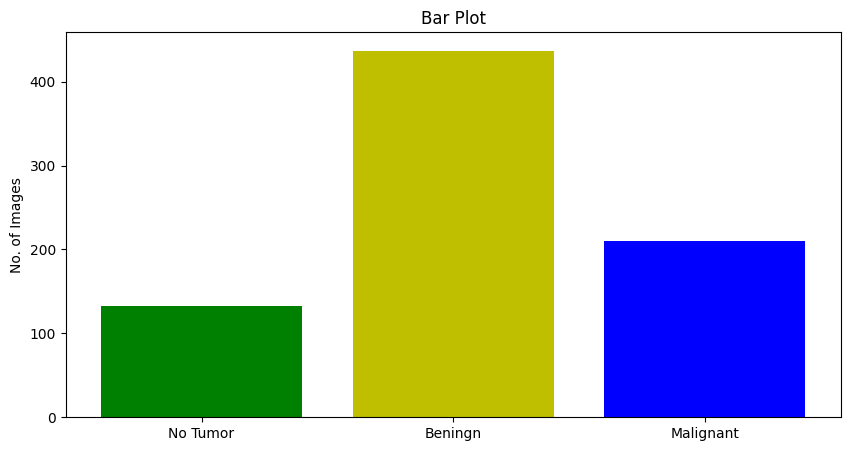

In [4]:
# plot the bar graph for number of benign and malignant images
fig = plt.figure(figsize = (10, 5))

plt.bar([0,1,2],[normal, benign, malignant], color = ['g', 'y', 'b'])
plt.xticks([0,1,2], ['No Tumor', 'Beningn', 'Malignant'])
plt.ylabel("No. of Images")
plt.title("Bar Plot") 
plt.show()

## Utility functions

In [5]:
## function to plot sample images
def sample_images(images, sample):
    figure, axes = plt.subplots(1, 6)
    figure.set_size_inches(35,25)
    axes[0].imshow(images[sample[0]], cmap='gray') 
    axes[0].title.set_text("No Tumor")
    axes[0].axis('off')
    axes[1].imshow(images[sample[1]], cmap='gray') 
    axes[1].title.set_text("No Tumor")
    axes[1].axis('off')
    axes[2].imshow(images[sample[2]], cmap='gray') 
    axes[2].axis('off')
    axes[2].title.set_text("Benign")
    axes[3].imshow(images[sample[3]], cmap='gray') 
    axes[3].axis('off')
    axes[3].title.set_text("Benign")
    axes[4].imshow(images[sample[4]], cmap='gray') 
    axes[4].axis('off')
    axes[4].title.set_text("Malignant")
    axes[5].imshow(images[sample[5]], cmap='gray') 
    axes[5].axis('off')
    axes[5].title.set_text("Malignant")
    plt.show()

In [6]:
# function to find the histogram of images
def draw_hist(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = np.zeros((256,1))
    for x in np.nditer(img):
        if x > 255:
            x = 255
        elif x < 0:
            x = 0
        hist[int(x)] = hist[int(x)] + 1
    return hist

## function to plot sample histogram of images
def plot_hist(images, sample, figsize=[30,3]):
    fig = plt.figure(figsize=figsize)
    plt.subplot(1,6,1)
    plt.plot(draw_hist(images[sample[0]]))
    plt.title('histogram for no tumor')
    plt.subplot(1,6,2)
    plt.plot(draw_hist(images[sample[1]]))
    plt.title('histogram for no tumor')
    plt.subplot(1,6,3)
    plt.plot(draw_hist(images[sample[2]]))
    plt.title('histogram for benign')
    plt.subplot(1,6,4)
    plt.plot(draw_hist(images[sample[3]]))
    plt.title('histogram for benign')
    plt.subplot(1,6,5)
    plt.plot(draw_hist(images[sample[4]]))
    plt.title('histogram for malignant')
    plt.subplot(1,6,6)
    plt.plot(draw_hist(images[sample[5]]))
    plt.title('histogram for malignant')
    plt.show()

## Image Preprocessing
In order to use a ML model capable to detect the presence of a tumor given an image as input we need to extract useful features

In [7]:
sample = [0, 22, 160, 400, 600, 650]

### Grayscale Image
First of all we convert all the image in gray scale

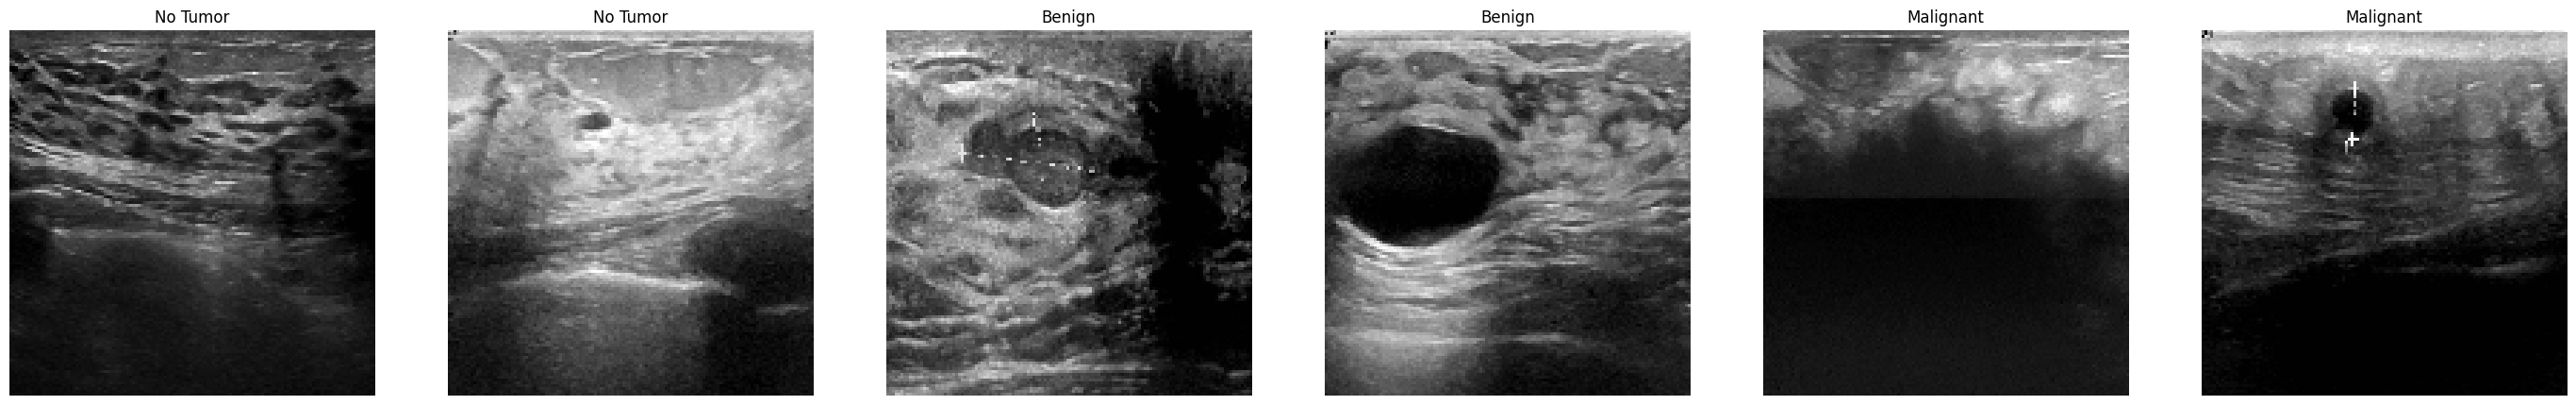

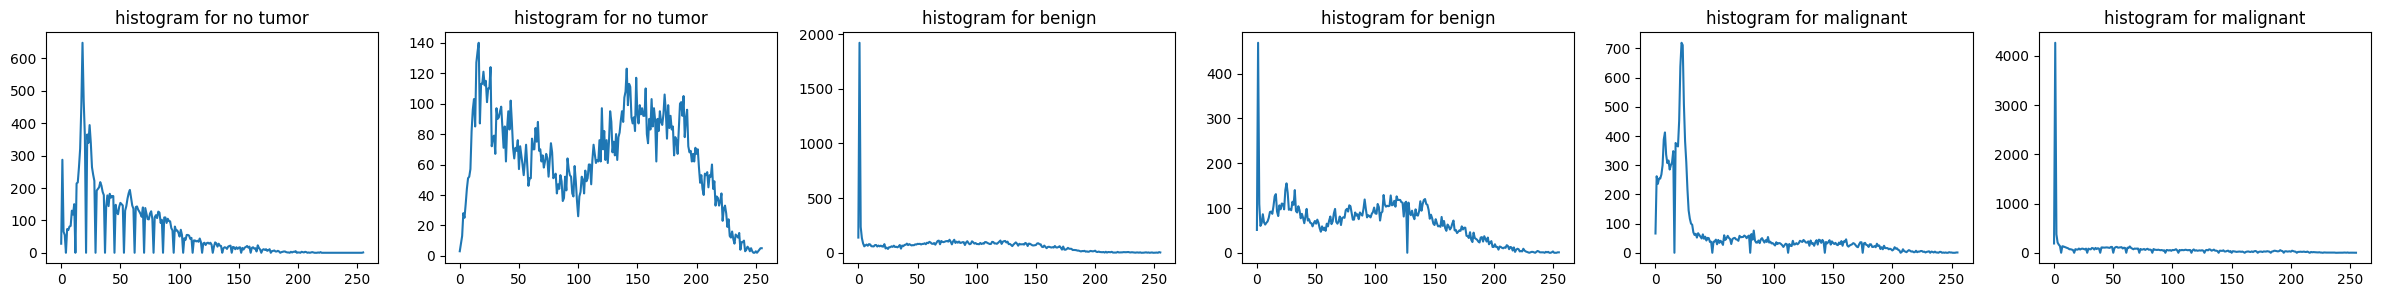

In [10]:
# convert the RBG images to gray scale images
grayscale_images = []
grayscale_images.clear()
for image in image_list:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale_images.append(gray_image)
sample_images(grayscale_images, sample)
plot_hist(grayscale_images, sample)

### Histogram Equalization
We compute histogram equalization that is a method in image processing of contrast adjustment using the image’s histogram.
This method usually increases the global contrast of many images, especially when the usable data of the image is represented by close contrast values. Through this adjustment, the intensities can be better distributed on the histogram. This allows for areas of lower local contrast to gain a higher contrast. Histogram equalization accomplishes this by effectively spreading out the most frequent intensity values. The method is useful in images with backgrounds and foregrounds that are both bright or both dark.

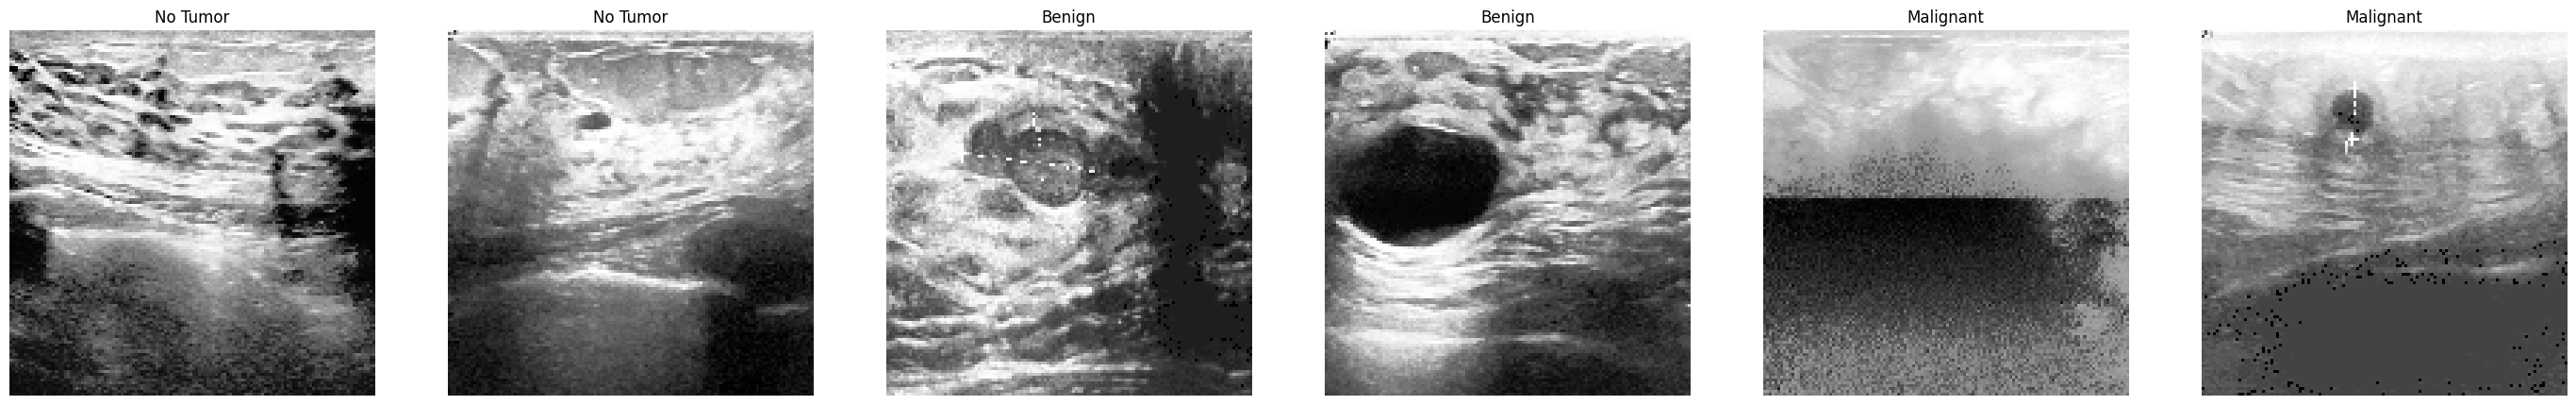

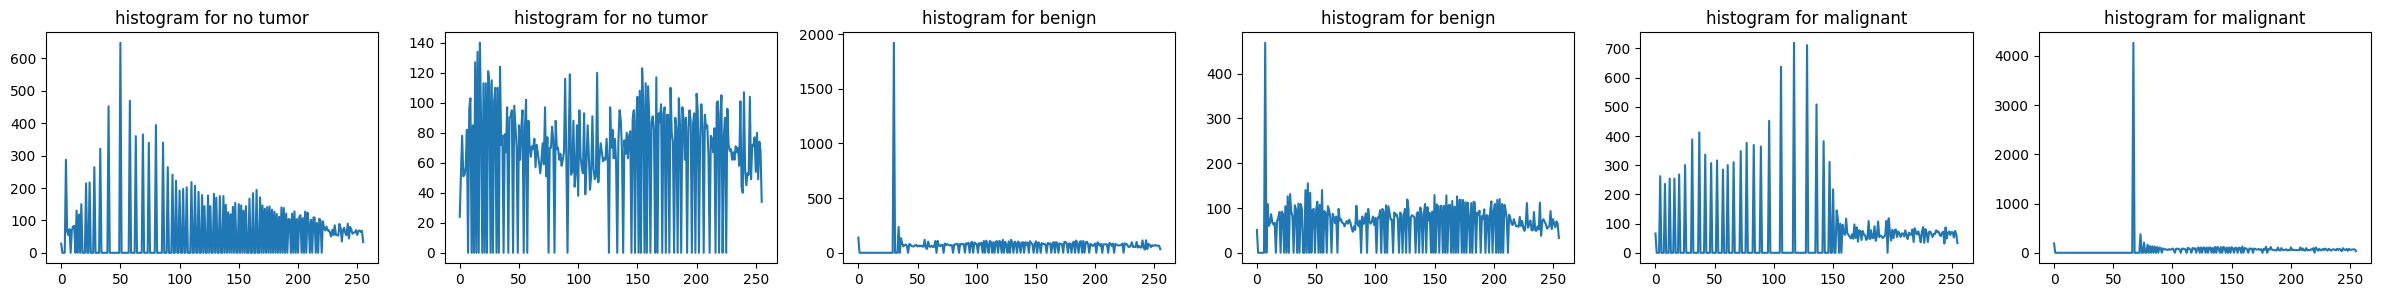

In [11]:
# histogram equalization on gray scale images
eqhist_images=[]
eqhist_images.clear()
for image in grayscale_images:
    eqhistimage = cv2.equalizeHist(image)
    eqhist_images.append(eqhistimage)
sample_images(eqhist_images, sample)
plot_hist(eqhist_images, sample)

### Bilateral Filter
A bilateral filter is used for smoothening images and reducing noise, while preserving edges. However, these convolutions often result in a loss of important edge information, since they blur out everything, irrespective of it being noise or an edge.

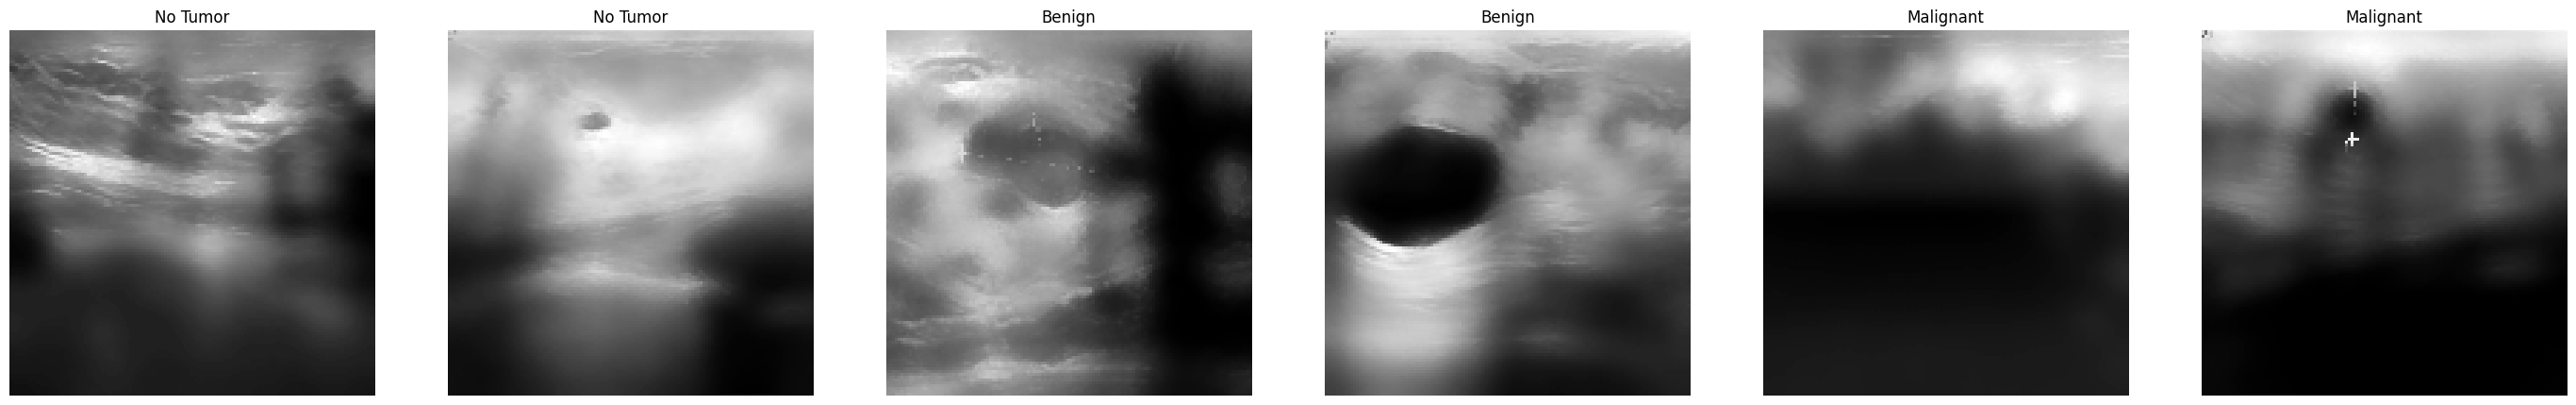

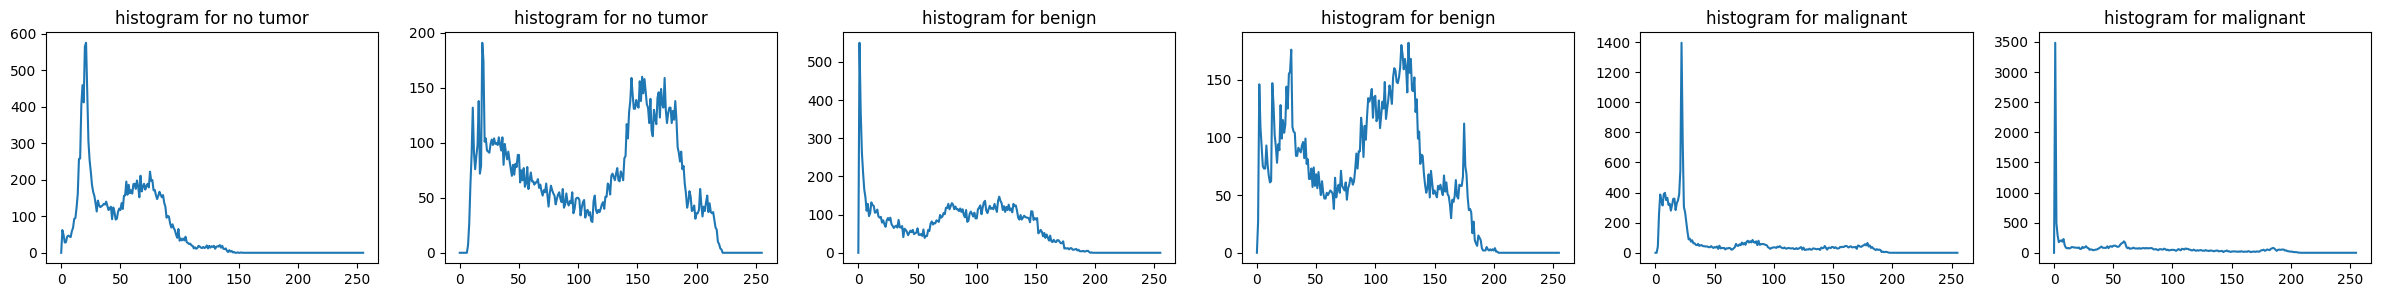

In [12]:
## Applying bilateral filter on grayscale images
bilateral_images = []
bilateral_images.clear()
for image in grayscale_images:
    bilateral = cv2.bilateralFilter(image, 15, 75, 75)
    bilateral_images.append(bilateral)
sample_images(bilateral_images, sample)
plot_hist(bilateral_images, sample)

### CLAHE
CLAHE is a variant of Adaptive histogram equalization (AHE) which takes care of over-amplification of the contrast. CLAHE operates on small regions in the image, called tiles, rather than the entire image. The neighboring tiles are then combined using bilinear interpolation to remove the artificial boundaries.  This algorithm can be applied to improve the contrast of images.

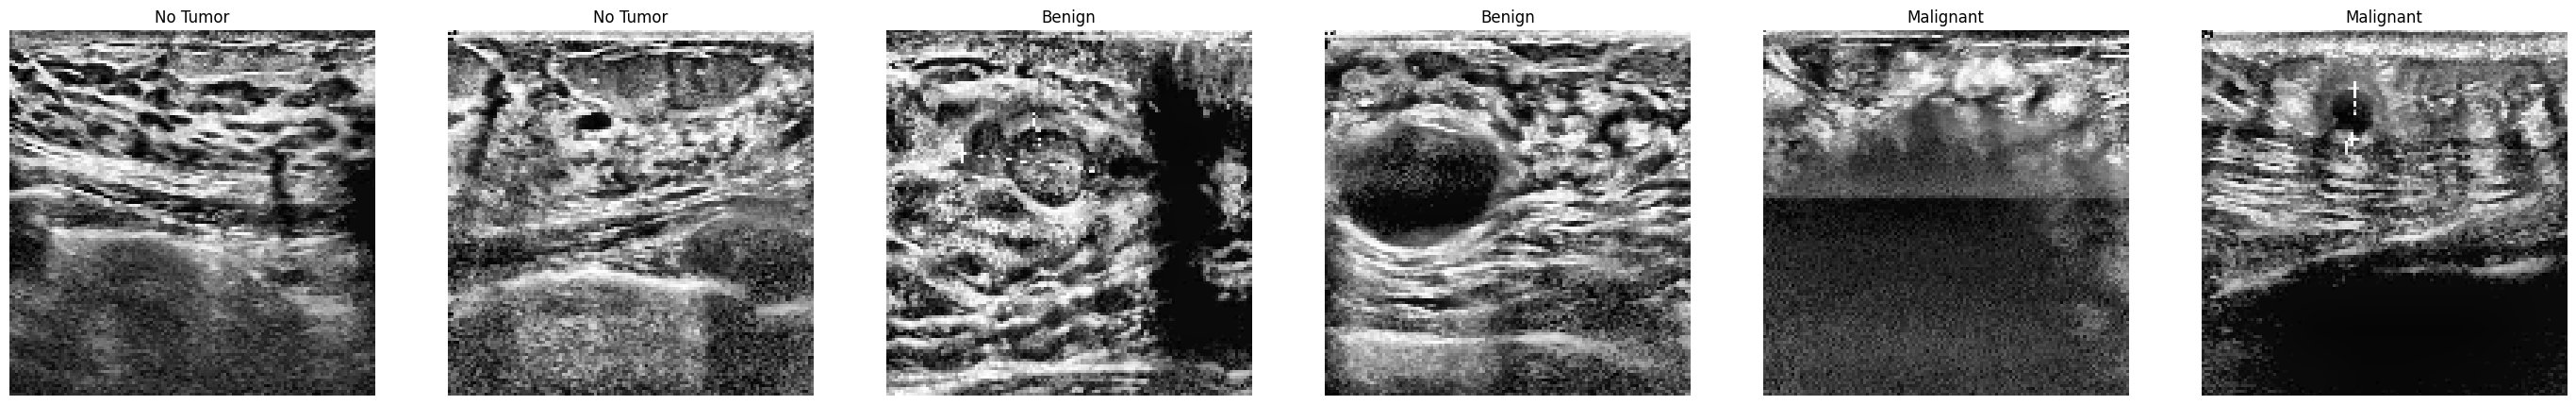

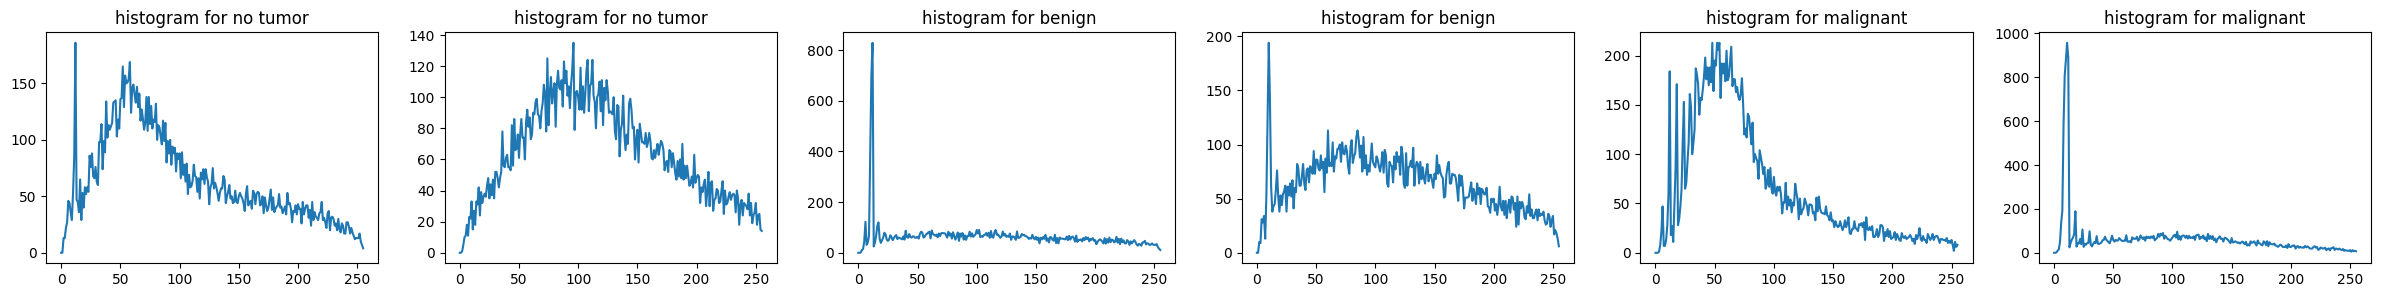

In [13]:
# applying clahe on grayscale images
Clahe_images=[]
Clahe_images.clear()
for image in grayscale_images:
    clahe = cv2.createCLAHE(clipLimit=5)
    clahe_img = clahe.apply(image) 
    Clahe_images.append(clahe_img)

sample_images(Clahe_images, sample)
plot_hist(Clahe_images, sample)

### Otsu Binarization

Otsu’s method is an adaptive thresholding way for binarization in image processing. It can find the optimal threshold value of the input image by going through all possible threshold values (from 0 to 255).

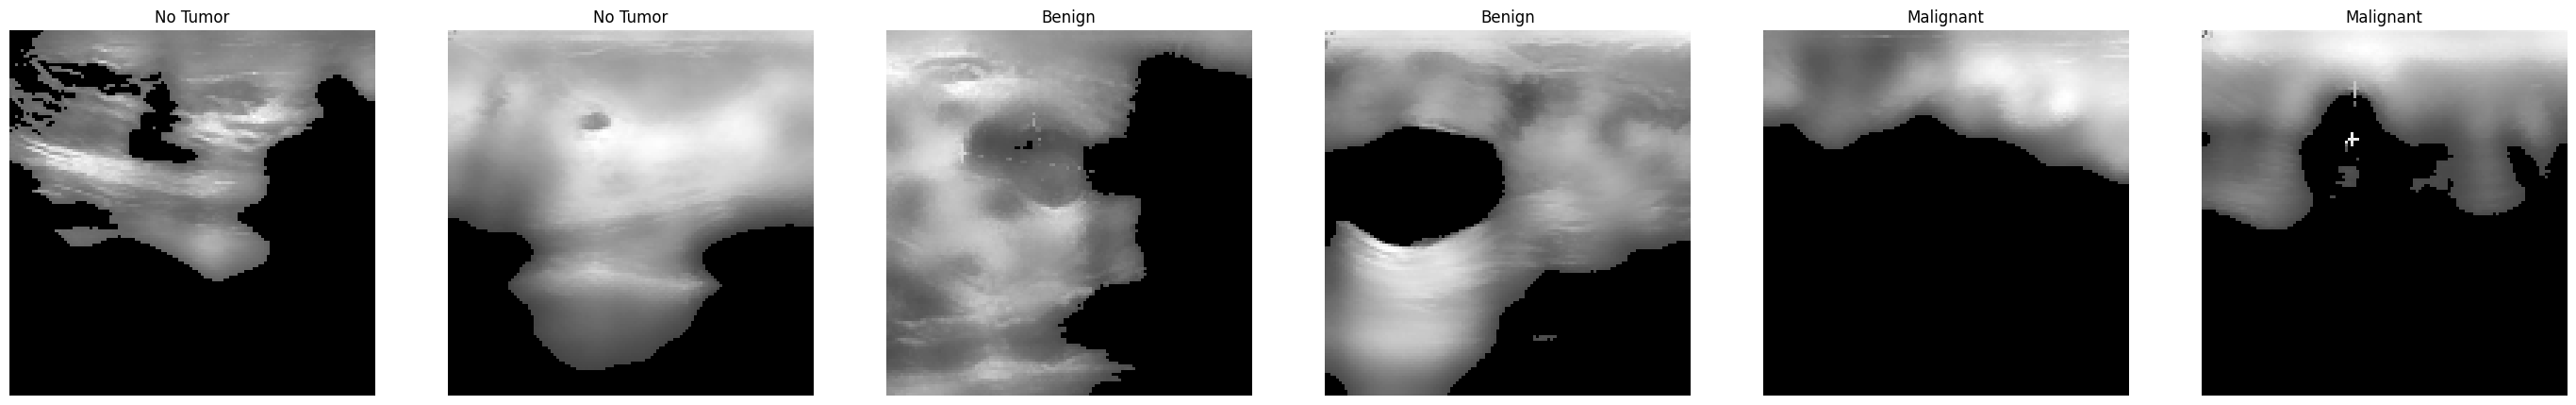

In [14]:
thresholded=[]
thresholded.clear()
for image in bilateral_images:
    thresh, binaryImg = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)
    ret, image = cv2.threshold(image, thresh-20, 255, cv2.THRESH_TOZERO)
    thresholded.append(image)
#(np.array(thresholded)).shape
sample_images(thresholded, sample)

### Adaptive Threshold

Adaptive thresholding is the method where the threshold value is calculated for smaller regions and therefore, there will be different threshold values for different regions.

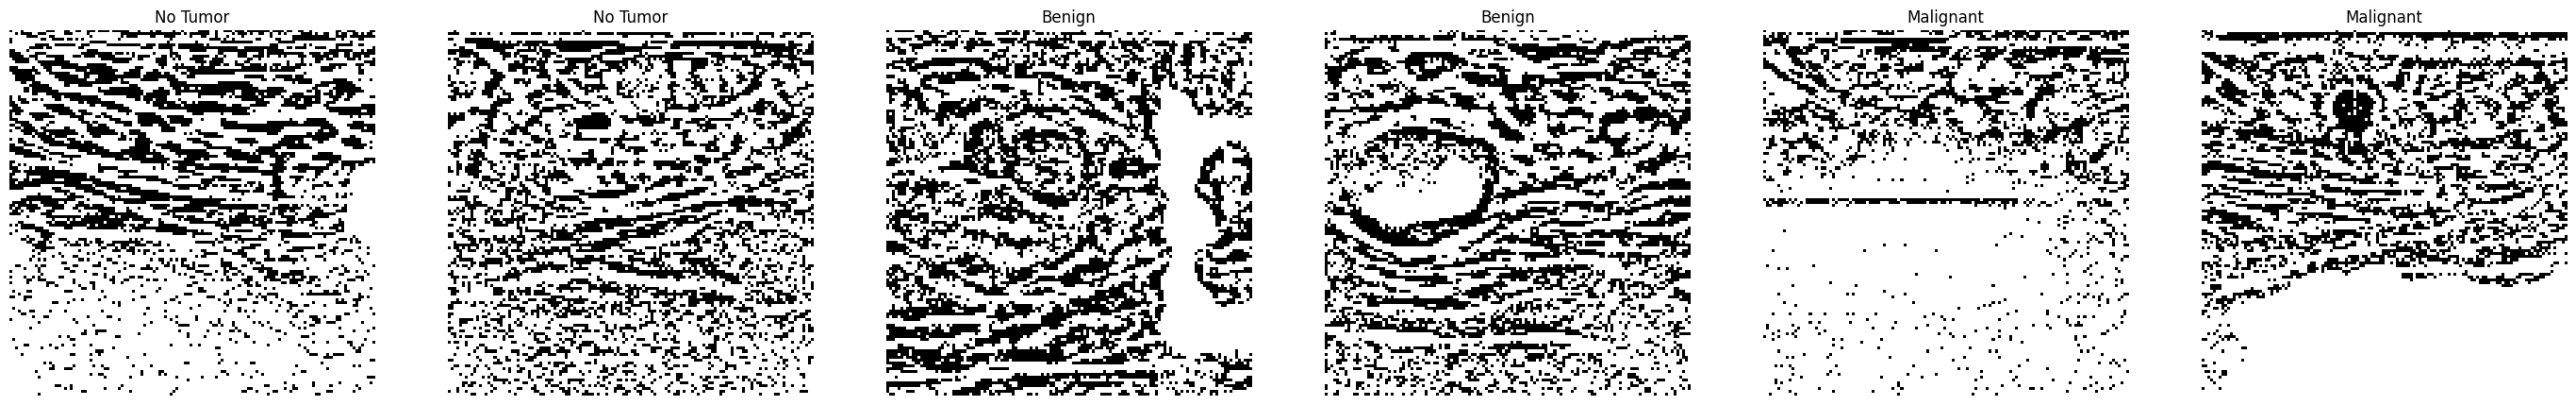

In [15]:
# Applied threshold to zero inversion
thresholded_images=[]
thresholded_images.clear()
for image in grayscale_images:
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 5)
    thresholded_images.append(image)
sample_images(thresholded_images, sample)

## Edge Detection

Edge detection is an image-processing technique that is used to identify the boundaries (edges) of objects or regions within an image. 

### Sobel Edge Detection

Sobel Edge Detection is one of the most widely used algorithms for edge detection. 
The Sobel Operator detects edges marked by sudden changes in pixel intensity.

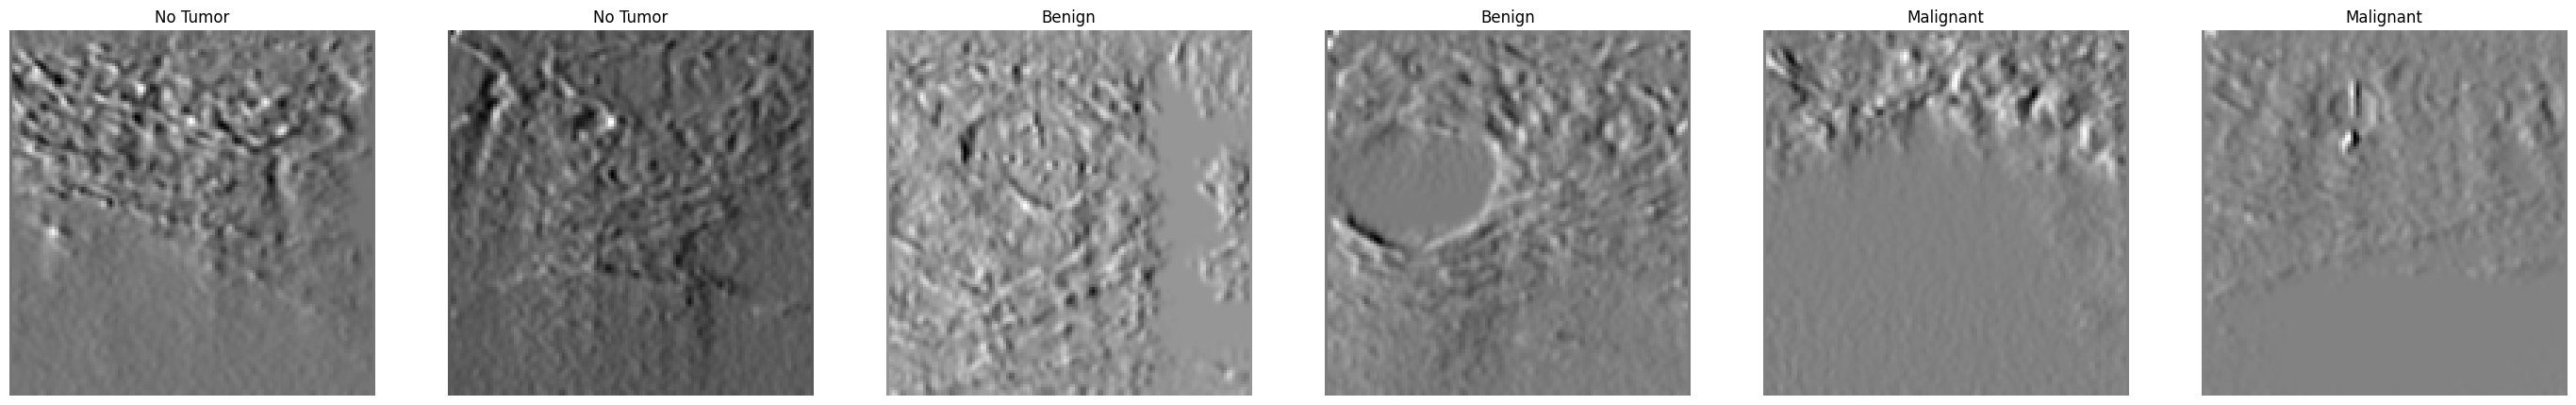

In [16]:
# Using sobel filter on grayscale images
x_edged_images=[]
x_edged_images.clear()
for image in grayscale_images:
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    x_edged_images.append(sobelx)
sample_images(x_edged_images, sample)

### Conny Edge Detection

Canny Edge Detection is one of the most popular edge-detection methods in use today because it is so robust and flexible. The algorithm itself follows a three-stage process for extracting edges from an image. Add to it image blurring, a necessary preprocessing step to reduce noise. 

This makes it a four-stage process, which includes:

- Noise Reduction
- Calculating the Intensity Gradient of the Image
- Suppression of False Edges
- Hysteresis Thresholding

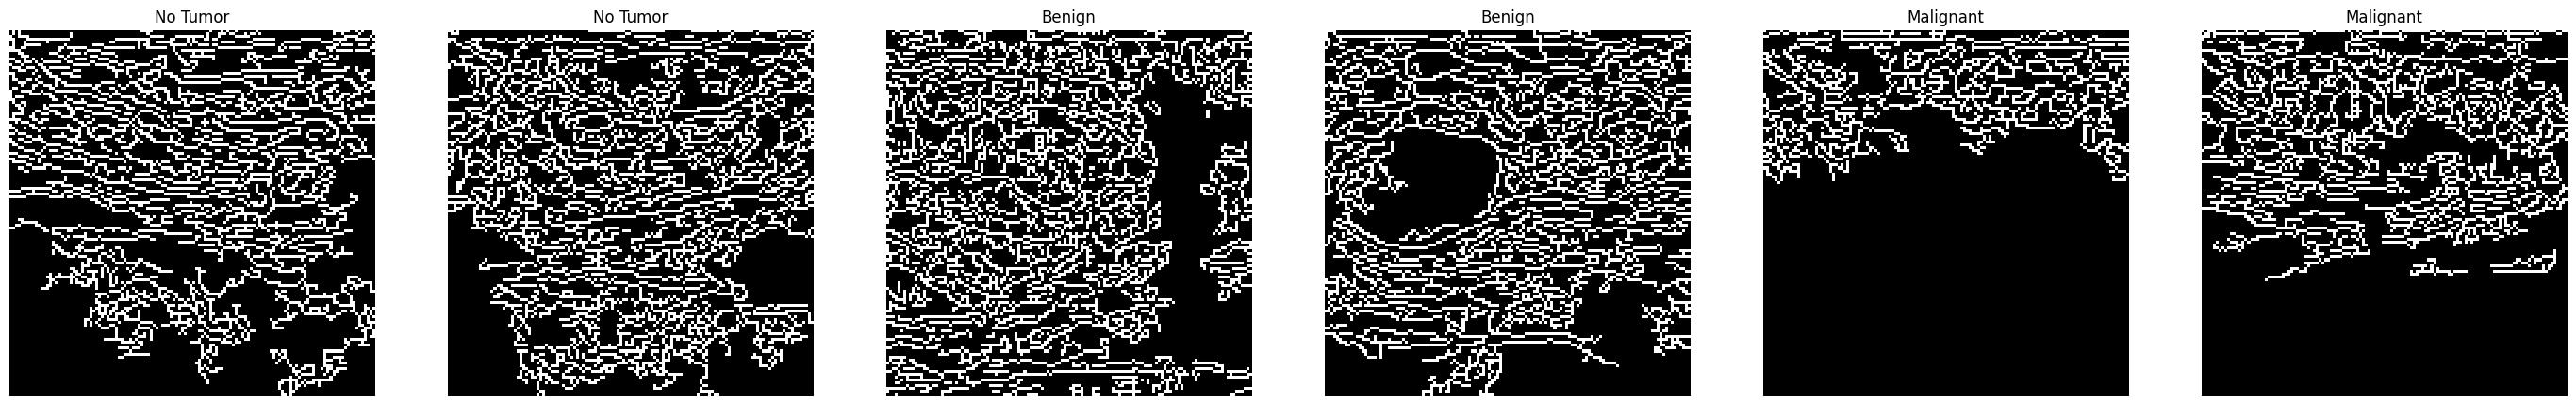

In [17]:
conny_edged_images=[]
conny_edged_images.clear()
for image in image_list:
    image = cv2.Canny(image, 10, 200)
    conny_edged_images.append(image)
sample_images(conny_edged_images, sample)

## Morphological Operations

Fundamentally morphological image processing is similar to spatial filtering. The structuring element is moved across every pixel in the original image to give a pixel in a new processed image. The value of this new pixel depends on the morphological operation performed. The two most widely used operations are Erosion and Dilation.

### Erosion

Erosion shrinks the image pixels, or erosion removes pixels on object boundaries. First, we traverse the structuring element over the image object to perform an erosion operation. The output pixel values are calculated using the following equation.
- Pixel(output) = 1 {if FIT}
- Pixel(output) = 0 {otherwise}

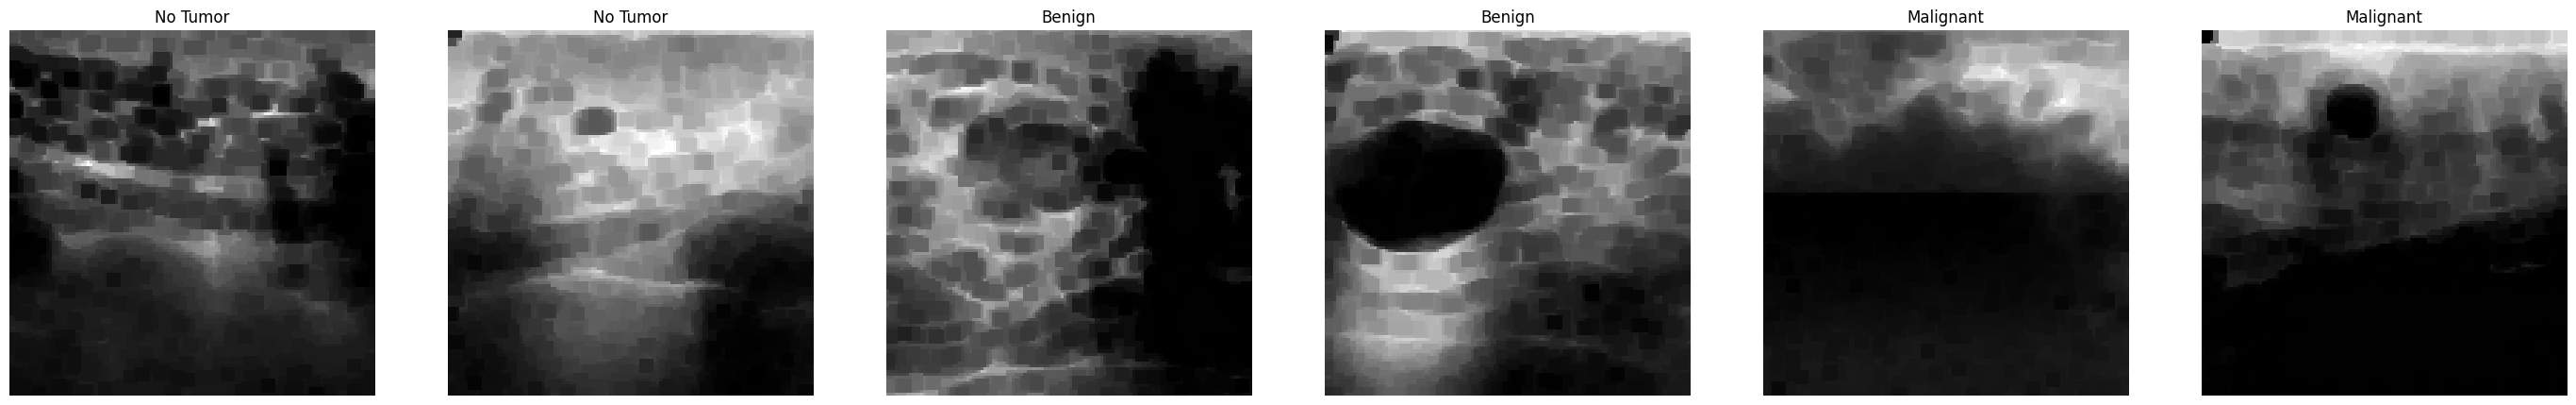

In [18]:
ero_images = []
ero_images.clear()
kernel = np.ones((5, 5), np.uint8)
for image in grayscale_images:
    erosion = cv2.erode(image, kernel, iterations=1)
    ero_images.append(erosion)
sample_images(ero_images, sample)

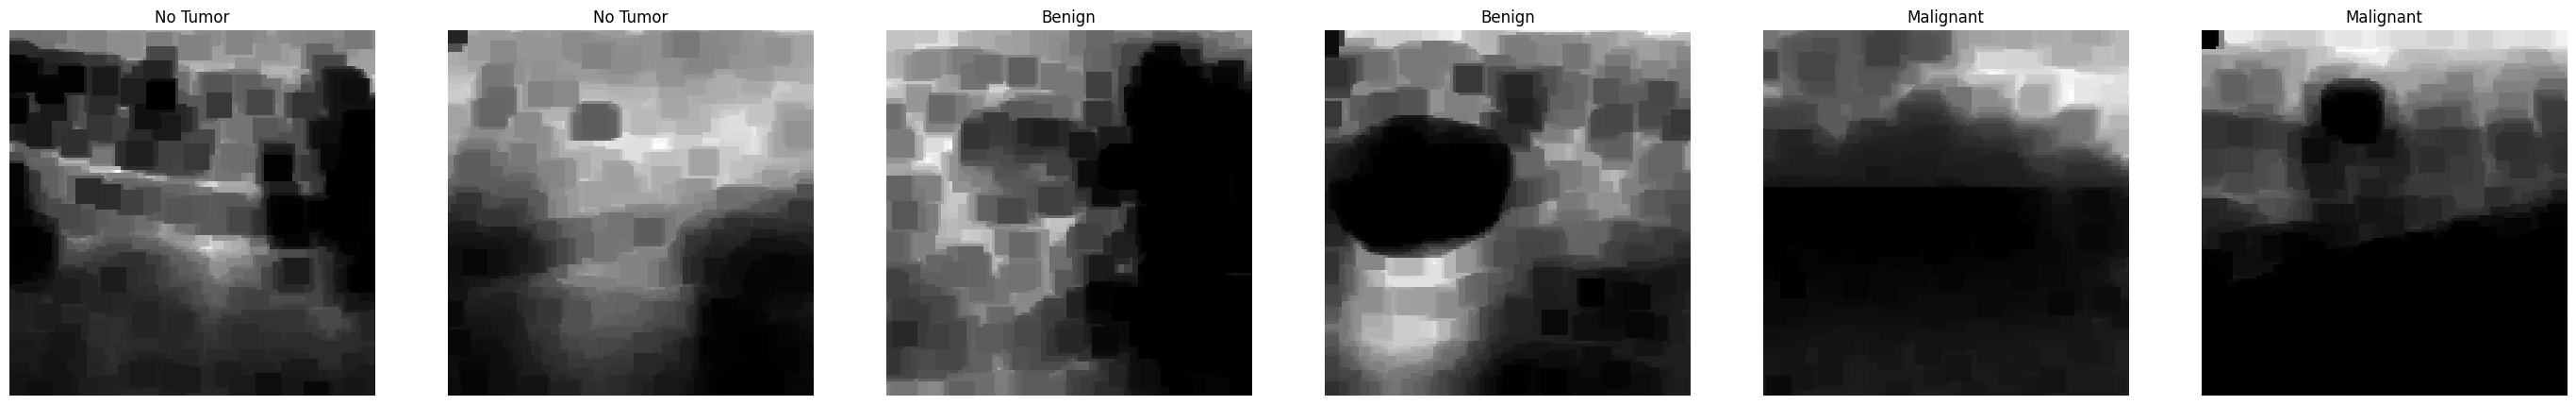

In [19]:
ero_images = []
ero_images.clear()
kernel = np.ones((3,3),np.uint8)
for image in grayscale_images:
    erosion = cv2.erode(image, kernel, iterations=2)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    erosion = cv2.erode(dilation, kernel, iterations=2)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    erosion = cv2.erode(dilation, kernel, iterations=2)
    ero_images.append(erosion)
sample_images(ero_images, sample)

### Dilation

Dilation expands the image pixels, or it adds pixels on object boundaries. First, we traverse the structuring element over the image object to perform an dilation operation. The output pixel values are calculated using the following equation.
- Pixel(output) = 1 {if HIT}
- Pixel(output) = 0 {otherwise}

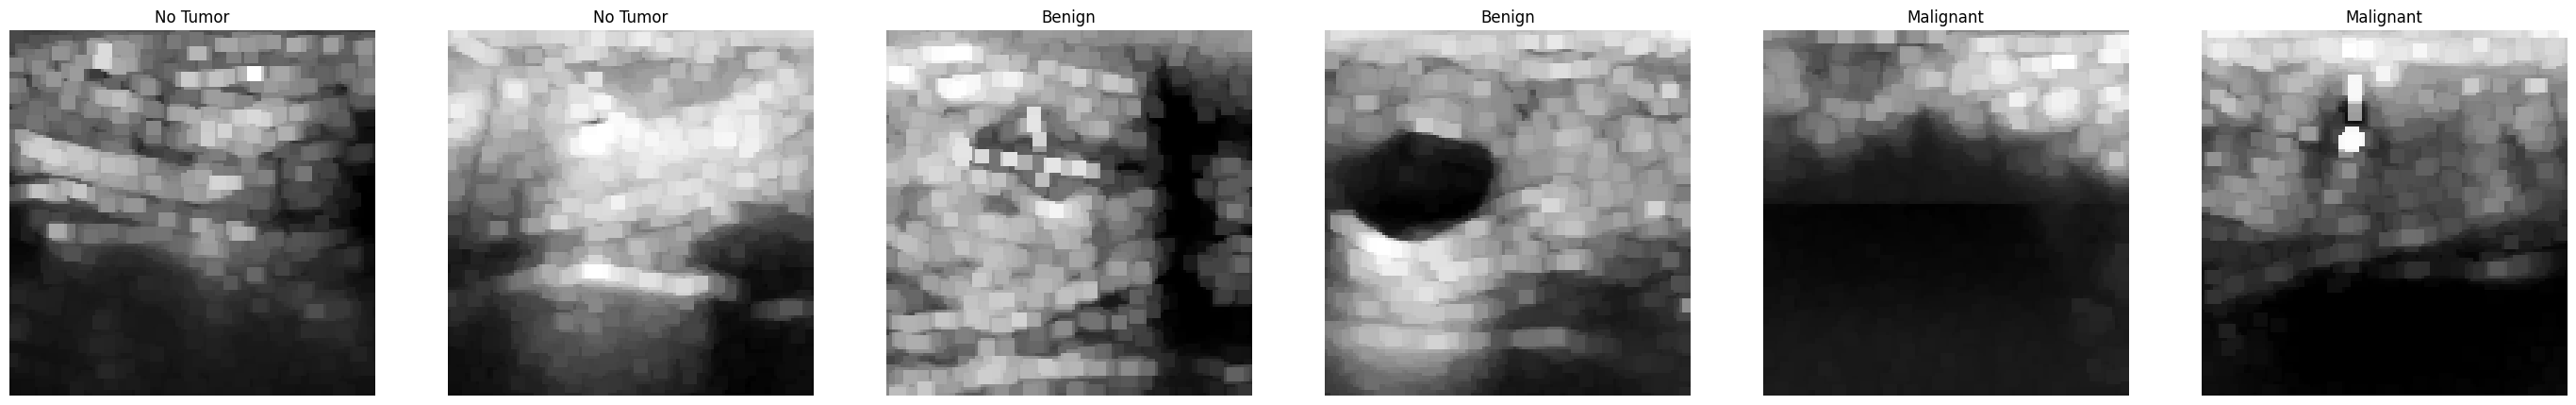

In [20]:
dilation_images = []
dilation_images.clear()
kernel = np.ones((5,5),np.uint8)
for image in grayscale_images:
    dilation = cv2.dilate(image, kernel, iterations=1)
    dilation_images.append(dilation)
sample_images(dilation_images, sample)

## Calculation Statistical and GLCM Features

For all the operato that we apply to the row images we compute mean and standard deviation and use it as features.

In addition we compute the GLCM. [Gray-Level Co-occurrence matrix](https://www.ijsrp.org/research-paper-0513/ijsrp-p1750.pdf) is a texture analysis method in digital image processing. This method represents the relationship between two neighboring pixels that have gray intensity, distance, and angle. In general, we use GLCM to get texture features in images such as dissimilarity, correlation, homogeneity, contrast, and entropy.

In [21]:
# calculating the GLCM features
Energy = []
Correlation = []
Dissimilarity = []
Homogenity = []
Contrast = []
Entropy = []


def energy(img):
    img = np.array(img)
    GLCM = graycomatrix(img, [1], [0])
    return graycoprops(GLCM, 'energy')[0]

def correlation(img):
    img = np.array(img)
    GLCM = graycomatrix(img, [1], [0])
    return graycoprops(GLCM, 'correlation')[0]

def dissimilarity(img):
    img = np.array(img)
    GLCM = graycomatrix(img, [1], [0])
    return  graycoprops(GLCM, 'dissimilarity')[0]

def homogenity(img):
    img = np.array(img)
    GLCM = graycomatrix(img, [1], [0])
    return  graycoprops(GLCM, 'homogeneity')[0]

def contrast(img):
    img = np.array(img)
    GLCM = graycomatrix(img, [1], [0])
    return graycoprops(GLCM, 'contrast')[0]

def entropy(img):
    img = np.array(img)
    GLCM = graycomatrix(img, [1], [0])
    return graycoprops(GLCM, 'entropy')[0]

for img in image_list:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    Energy.append(energy(img)[0])
    Correlation.append(correlation(img)[0])
    Dissimilarity.append(dissimilarity(img)[0])
    Homogenity.append(homogenity(img)[0])
    Contrast.append(contrast(img)[0])
    Entropy.append(contrast(img)[0]) 

In [22]:
## mean and standard deviation of grayscale images
gray_mean=[]
gray_std_dev=[]
gray_mean.clear()
gray_std_dev.clear()
for image in grayscale_images:
    gray_mean.append(np.mean(image))
    gray_std_dev.append(np.std(image))

In [23]:
## calculating mean and standard deviation of histogram equalization images
Histeq_mean=[]
Histeq_std=[]
Histeq_mean.clear()
Histeq_std.clear()
for image in eqhist_images:
    Histeq_mean.append(np.mean(image))
    Histeq_std.append(np.std(image))

In [24]:
## mean and standard deviation of clahe images
clahe_mean=[]
clahe_std_dev=[]
clahe_mean.clear()
clahe_std_dev.clear()
for image in Clahe_images:
    clahe_mean.append(np.mean(image))
    clahe_std_dev.append(np.std(image))

In [25]:
## mean and standard deviation of adative histogram equalization images
adaptive_mean=[]
adaptive_std_dev=[]
adaptive_mean.clear()
adaptive_std_dev.clear()
for image in thresholded:
    adaptive_mean.append(np.mean(image))
    adaptive_std_dev.append(np.std(image))

In [26]:
## mean and standard deviation of clahe images
sobel_mean=[]
sobel_std_dev=[]
sobel_mean.clear()
sobel_std_dev.clear()
for image in x_edged_images:
    sobel_mean.append(np.mean(image))
    sobel_std_dev.append(np.std(image))

In [27]:
## calculating mean and standard deviation of erosed images 
er_mean=[]
er_std_dev=[]
er_mean.clear()
er_std_dev.clear()
for image in ero_images:
    er_mean.append(np.mean(image))
    er_std_dev.append(np.std(image))

In [28]:
# calculating the mean and standard deviation of dilated images
dl_mean=[]
dl_mean.clear()
dl_std_dev=[]
dl_std_dev.clear()
for image in enumerate(dilation_images):
    dl_mean.append(np.mean(image))
    dl_std_dev.append(np.std(image))

In [29]:
# Make a dataframe of all features.
data = pd.DataFrame({
                    'gray_mean':gray_mean,
                    'gray_std_dev':gray_std_dev,
                    'adaptive_mean':adaptive_mean,
                    'adaptive_std_dev':adaptive_std_dev,
                    'clahe_mean':clahe_mean,
                    'clahe_std_dev':clahe_std_dev,
                    'sobel_std_dev':sobel_std_dev,
                    'sobel_mean':sobel_mean,
                    'er_mean':er_mean,
                    'er_std_dev':er_std_dev,
                    'Histeq_mean':Histeq_mean,
                    'Histeq_std':Histeq_std,
                    'dl_mean':dl_mean,
                    'dl_std_dev':dl_std_dev,
                    'Entropy':Entropy,
                    'Energy':Energy,
                    'Correlation':Correlation,
                    'Dissimilarity': Dissimilarity,
                    'Homogenity':Homogenity,
                    'Contrast':Contrast,
                    'label':output
                    })

data.to_csv('./Dataset_BUSI_with_GT/Features.csv', index=False)